In [1]:
import pandas as pd
import numpy as np

In [2]:
path = 'c:/data/elo/'
train_path = 'train.csv'
test_path = 'test.csv'
historical_transactions_path = 'historical_transactions.csv'
new_merchant_transactions_path = 'new_merchant_transactions.csv'
merchants_path= 'merchants.csv'

In [3]:
%matplotlib inline

In [4]:
import telepot
def send_notify(text):
    with open('../../_access_keys/telegram_token.txt', 'r') as content_file:
        token = content_file.read()
    with open('../../_access_keys/user.txt', 'r') as content_file:
        user = content_file.read()
    try:
        TelegramBot = telepot.Bot(token)
        TelegramBot.sendMessage(int(user), text)
    except:
        pass

In [5]:
from keras.callbacks import Callback
from matplotlib import pyplot as plt
from IPython.display import clear_output
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize=(15,10))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="validation loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
from sklearn import preprocessing
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, GlobalMaxPooling1D, GRU, Bidirectional, LSTM, concatenate
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import regularizers

# analyze

In [8]:
train = pd.read_csv(path + train_path)

In [9]:
train.shape

(201917, 6)

In [10]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [11]:
train['feature_3'].unique()

array([1, 0], dtype=int64)

In [76]:
train['is_train'] = True

In [12]:
test = pd.read_csv(path + test_path)

In [13]:
test.shape

(123623, 5)

In [72]:
test.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-04,C_ID_0ab67a22ab,3,3,1,NaN
1,2017-01,C_ID_130fd0cbdd,2,3,0,NaN
2,2017-08,C_ID_b709037bc5,5,1,1,NaN
3,2017-12,C_ID_d27d835a9f,2,1,0,NaN
4,2015-12,C_ID_2b5e3df5c2,5,1,1,NaN


In [77]:
test['target'] = np.nan
test['is_train'] = False

In [78]:
data = pd.concat((train, test))

## historical_transactions 

In [15]:
historical_transactions = pd.read_csv(path + historical_transactions_path)

In [16]:
historical_transactions.shape

(29112361, 14)

In [60]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0,0.0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0,0.0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0,0.0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0,0.0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0,0.0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [63]:
historical_transactions['installments'].value_counts()

 0      15411747
 1      11677522
 2        666416
 3        538207
 4        179525
-1        178159
 6        132634
 10       118827
 5        116090
 12        55064
 8         20474
 7         10906
 9          5772
 11          830
 999         188
Name: installments, dtype: int64

In [58]:
historical_transactions['category_1'].replace({'N':0, 'Y':1}, inplace=True)
historical_transactions['category_3'].replace({'A':0, 'B':1, 'C':2}, inplace=True)
historical_transactions['authorized_flag'].replace({'N':0, 'Y':1}, inplace=True)

In [79]:
data.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,is_train
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,True
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,True
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,True
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,True
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,True


In [108]:
sum_purchases = historical_transactions.groupby(['card_id'])[['card_id', 'purchase_amount']].sum().reset_index()

In [110]:
data = data.merge(sum_purchases, how='left', left_on='card_id', right_on='card_id')

In [112]:
data.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,is_train,purchase_amount
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,True,-165.968739
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,True,-210.006336
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,True,-29.167391
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,True,-49.491364
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,True,-48.687656


## new_merchant_transactions 

In [19]:
new_merchant_transactions = pd.read_csv(path + new_merchant_transactions_path)

In [20]:
new_merchant_transactions.shape

(1963031, 14)

In [51]:
new_merchant_transactions.head()

,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,C_ID_415bb3a509,107,0,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,C_ID_415bb3a509,140,0,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,C_ID_415bb3a509,330,0,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,C_ID_415bb3a509,-1,1,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,C_ID_ef55cf8d4b,-1,1,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [34]:
new_merchant_transactions.drop('authorized_flag', axis=1, inplace=True)

In [49]:
new_merchant_transactions['category_1'].replace({'N':0, 'Y':1}, inplace=True)

In [50]:
new_merchant_transactions['category_1'].value_counts()

0    1899935
1      63096
Name: category_1, dtype: int64

## merchants 

In [23]:
merchants = pd.read_csv(path + merchants_path)

In [24]:
merchants.shape

(334696, 22)

In [25]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [26]:
merchants['most_recent_sales_range'].unique()

array(['E', 'C', 'D', 'A', 'B'], dtype=object)

# train

In [113]:
data.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,is_train,purchase_amount
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,True,-165.968739
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,True,-210.006336
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,True,-29.167391
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,True,-49.491364
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,True,-48.687656


In [118]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_1,325540.0,0.526703,0.296820,0.000000,0.250000,0.500000,0.750000,1.000000
feature_2,325540.0,0.372019,0.375270,0.000000,0.000000,0.500000,0.500000,1.000000
feature_3,325540.0,0.565116,0.495742,0.000000,0.000000,1.000000,1.000000,1.000000
target,201917.0,-0.393636,3.850500,-33.219281,-0.883110,-0.023437,0.765453,17.965068
purchase_amount,325540.0,0.000598,0.001767,0.000000,0.000587,0.000593,0.000596,1.000000


In [116]:
target_columns = ['feature_1', 'feature_2', 'feature_3', 'purchase_amount']

In [117]:
for i in target_columns:
    data[i] -= data[i].min()
    data[i] /= data[i].max()

In [120]:
X = data[data['is_train']][target_columns]

In [119]:
y = data[data['is_train']]['target']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [122]:
X_train.describe()

,feature_1,feature_2,feature_3,purchase_amount
count,161533.000000,161533.000000,161533.000000,161533.000000
mean,0.526078,0.372726,0.564665,0.000602
std,0.296627,0.375696,0.495802,0.002498
min,0.000000,0.000000,0.000000,0.000251
25%,0.250000,0.000000,0.000000,0.000587
50%,0.500000,0.500000,1.000000,0.000593
75%,0.750000,0.500000,1.000000,0.000596
max,1.000000,1.000000,1.000000,1.000000


In [123]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [124]:
def create_model():
    #build Keras model
    
    x_input = Input(shape=X_train.shape[1:], dtype='float32')

    x_layer = Dense(X_train.shape[-1], activation="relu", kernel_initializer="normal")(x_input)
    x_layer = Dense(1, activation="relu", kernel_initializer="normal")(x_layer)

    model = Model(x_input, x_layer)
    model.compile(loss='mean_squared_error', metrics=['mae'], optimizer='rmsprop')
    return model

In [125]:
count_epochs = 100
model = create_model()
early_stopping_monitor = EarlyStopping(patience=10)
history = model.fit(np.array(X_train), np.array(y_train), batch_size = 64, epochs = count_epochs, verbose=1, validation_split=0.2, callbacks=[early_stopping_monitor])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 129226 samples, validate on 32307 samples
Epoch 1/100
129226/129226 [==============================] - 2s 18us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 2/100
129226/129226 [==============================] - 3s 20us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 3/100
129226/129226 [==============================] - 2s 16us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 4/100
129226/129226 [==============================] - 2s 16us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 5/100
129226/129226 [==============================] - 2s 16us/step - loss: 14.9865 - mean_absolute_error: 1.5449 - val_loss: 14.7089 - val_mean_absolute_error: 1.5313
Epoch 

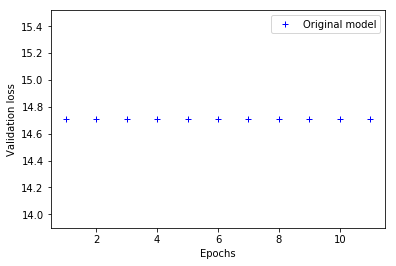

In [126]:
history_gr = history.history['val_loss']
epochs = range(1, len(history_gr) + 1)
import matplotlib.pyplot as plt

plt.plot(epochs, history_gr, 'b+', label='Original model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [127]:
predict = model.predict(np.array(X_test))
score = root_mean_squared_error(y_test, predict[0])
print("Total roc auc score = {0:0.4f}".format(score))

TypeError: unsupported format string passed to Tensor.__format__

In [128]:
predict.max()

0.0